### Imports

In [1]:
from __future__ import print_function, division
import os, mimetypes
import torch
import pandas as pd
import PIL
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from random import shuffle
from scipy import ndimage

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
path = Path('C:/Users/francesco.pochetti/Downloads/imagenette')

### Restructure dataset in convenient way

In [4]:
content_path = path/'imagenette-160'

In [5]:
content_path

WindowsPath('C:/Users/francesco.pochetti/Downloads/imagenette/imagenette-160')

In [6]:
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [7]:
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res
                
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [8]:
files = get_files(content_path, image_extensions, recurse=True)

In [9]:
len(files)

13394

In [10]:
van_gogh_path = path/'styles'/'VanGoghResized.png' 
van_gogh_path

WindowsPath('C:/Users/francesco.pochetti/Downloads/imagenette/styles/VanGoghResized.png')

In [11]:
contents = files
styles = [van_gogh_path] * len(contents)

In [12]:
te_ = int(len(styles) * 0.2)
tr_ = len(styles) - te_
assert(len(styles) == (te_+tr_))
print(te_, tr_)

splits = ['valid'] * te_ + ['train'] * tr_ 
shuffle(splits)

2678 10716


In [13]:
df = pd.DataFrame({'content_': contents, 'style_': styles, 'split_': splits})
df.head()

,content_,style_,split_
0,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,train
1,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,valid
2,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,train
3,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,valid
4,C:\Users\francesco.pochetti\Downloads\imagenet...,C:\Users\francesco.pochetti\Downloads\imagenet...,train


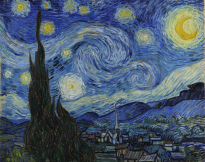

In [14]:
style_img = PIL.Image.open(df.sample().style_.iloc[0]); style_img

In [40]:
(style_img.size + (3,))

(205, 162, 3)

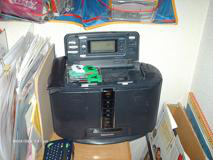

In [15]:
content_img = PIL.Image.open(df.sample().content_.iloc[0]); content_img

In [16]:
df.to_csv(path/'dataset.csv', index=False)

### Prepare the dataset/dataloader

In [8]:
class StyleTransferDataset(Dataset):
    """Style Transfer dataset."""

    def __init__(self, csv_file, train_test, transform=None):
        data = pd.read_csv(csv_file)
        self.train_test = train_test
        data.loc[:,['content_', 'style_']] = data.loc[:,['content_', 'style_']].applymap(lambda x: Path(x))
        self.data = data.loc[data.split_==train_test,:]
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        item = self.__getitem__(0)
        item = {'input': item[0].shape,
                'content': item[1].shape, 
                'style': item[2].shape}
        #{k: v.shape for k, v in self.__getitem__(0).items()}
        return f'{self.train_test.capitalize()} dataset: {len(self.data)} items\nItem example: {item}'

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        content_img = self.data.content_.iloc[idx]
        content_img = PIL.Image.open(content_img)
        
        style_img = self.data.style_.iloc[idx]
        style_img = PIL.Image.open(style_img)
        
        opt_img = np.random.uniform(0, 1, size=(content_img.size + (3,))).astype(np.float32)
        opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
        
        item = {'input': PIL.Image.fromarray(np.uint8(opt_img*255)),
                'content': content_img, 
                'style': style_img}

        if self.transform: item = compose(item, self.transform)

        return item['input'], item['content'], item['style']

In [3]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(list(funcs), key=key): x = f(x, **kwargs)
    return x

class Transform(): _order=0
        
class MakeRGB(Transform):
    def __call__(self, item): return {k: v.convert('RGB') for k, v in item.items()}

class ResizeFixed(Transform):
    _order=10
    def __init__(self, size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return {k: v.resize(self.size, PIL.Image.BILINEAR) for k, v in item.items()}

class ToByteTensor(Transform):
    _order=20
    def to_byte_tensor(self, item):
        res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
        w,h = item.size
        return res.view(h,w,-1).permute(2,0,1)
    
    def __call__(self, item): return {k: self.to_byte_tensor(v) for k, v in item.items()}


class ToFloatTensor(Transform):
    _order=30
    def to_float_tensor(self, item): return item.float().div_(255.)
    
    def __call__(self, item): return {k: self.to_float_tensor(v) for k, v in item.items()}
    
class Normalize(Transform):
    _order=40
    def __init__(self, stats):
        self.mean = torch.as_tensor(stats[0] , dtype=torch.float32)
        self.std = torch.as_tensor(stats[1] , dtype=torch.float32)
    
    def normalize(self, item): return item.sub_(self.mean[:, None, None]).div_(self.std[:, None, None])
    
    def __call__(self, item): return {k: self.normalize(v) for k, v in item.items()}
    
class DeProcess(Transform):
    _order=50
    def __init__(self, stats):
        self.mean = torch.as_tensor(stats[0] , dtype=torch.float32)
        self.std = torch.as_tensor(stats[1] , dtype=torch.float32)
    
    def de_normalize(self, item): return (item*self.std[:, None, None]+self.mean[:, None, None])*255.
    def rearrange_axis(self, item): return np.moveaxis(item, 0, -1)
    def to_np(self, item): return np.uint8(np.array(item))
    def de_process(self, item): return self.rearrange_axis(self.to_np(self.de_normalize(item)))
    
    def __call__(self, item): return {k: self.de_process(v) for k, v in item.items()}

In [22]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]
            
def collate(b):
    inputs,contents,styles = zip(*b)
    return torch.stack(inputs),torch.stack(contents),torch.stack(styles)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [23]:
rgb = MakeRGB()
resized = ResizeFixed(128)
tobyte = ToByteTensor()
tofloat = ToFloatTensor()
norm = Normalize(imagenet_stats)

tmfs = [rgb, resized, tobyte, tofloat, norm]

train_ds = StyleTransferDataset(path/'dataset.csv', train_test='train', transform=tmfs)
len(train_ds)

10716

In [24]:
sampler = Sampler(train_ds,4,True)
dl = DataLoader(train_ds,sampler)

In [25]:
i,c,s = next(iter(dl))

In [26]:
i.shape, c.shape, s.shape

(torch.Size([4, 3, 128, 128]),
 torch.Size([4, 3, 128, 128]),
 torch.Size([4, 3, 128, 128]))

In [12]:
train_ds

Train dataset: 10716 items
Item example: {'input': torch.Size([3, 128, 128]), 'content': torch.Size([3, 128, 128]), 'style': torch.Size([3, 128, 128])}

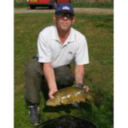

In [106]:
denorm = DeProcess(imagenet_stats)
d = denorm(train_ds[0])
PIL.Image.fromarray(d['content'])

In [47]:
len(train_ds)

10716